In [1]:
import sys
#add the path were the models are
sys.path.append("../inProduction/")
import pandas as pd
import numpy as np
from functools import reduce
from sirGA import SIR_GA
from sirPSO import SIR_PSO
from bootstrap import bootstrapTS as bsTS
import matplotlib.pyplot as plt
#set default theme for plts
import time

In [2]:
data = pd.read_csv("../data/dadosCovid.csv")
data.head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
0,Norte,RO,2020-01-30,0,0,0,0
1,Norte,RO,2020-01-31,0,0,0,0
2,Norte,RO,2020-02-01,0,0,0,0
3,Norte,RO,2020-02-02,0,0,0,0
4,Norte,RO,2020-02-03,0,0,0,0


In [3]:
#Select only Sao Paulo
sp = data[data["estado"] == "SP"]
#Remove missing values to not crash the intervals
sp = sp.dropna()
sp.head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
1501,Sudeste,SP,2020-02-26,1,1,0,0
1502,Sudeste,SP,2020-02-27,0,1,0,0
1503,Sudeste,SP,2020-02-28,0,1,0,0
1504,Sudeste,SP,2020-02-29,1,2,0,0
1505,Sudeste,SP,2020-03-01,0,2,0,0


In [4]:
#create a series with the cummulative number of cases
y = np.array(sp["casosAcumulados"])

#Give the number of days since the day of first case confirmed
x = range(0,len(sp["casosAcumulados"]))

In [5]:
model = SIR_PSO(50000000)
ci = bsTS()

In [6]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 10, simulation = "Poisson")

pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.24e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.24e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.22e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.34e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.14e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.27e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.16e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.17e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.07e+6
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.22e+6


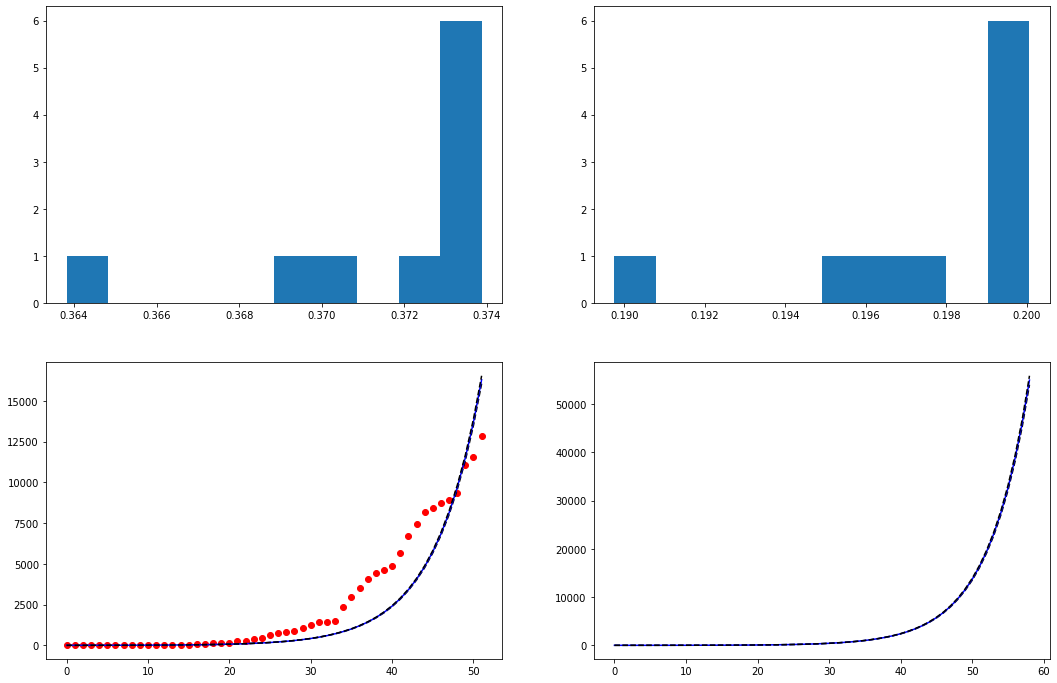

In [7]:
ci.plotParam(results)

In [ ]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 100, simulation = "Poisson", method = "approximation")

In [ ]:
ci.plotParam(results)

In [ ]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 100, simulation = "Poisson", method = "basic")

In [ ]:
ci.plotParam(results)

In [ ]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 100, simulation = "Mixing_Poisson")

In [ ]:
ci.plotParam(results)

In [ ]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 100, simulation = "Mixing_Poisson", method = "approximation")

In [ ]:
ci.plotParam(results)

In [ ]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 100, simulation = "Mixing_Poisson", method = "basic")

In [ ]:
ci.plotParam(results)

In [ ]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 100, simulation = "Gamma_Poisson")

In [ ]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 100, simulation = "Gamma_Poisson",method = "basic")

In [ ]:
ci.plotParam(results)

In [ ]:
results = ci.single_core_CI(model = model, y = y, x = x, ndays = 7, bootstrap = 100, simulation = "Gamma_Poisson", method = "approximation")

In [ ]:
ci.plotParam(results)